In [1]:
%load_ext autoreload
import os
import sys

In [2]:
os.environ['TRANSFORMERS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ['HF_DATASETS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ["OPENAI_API_KEY"]= 'xxx'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
sys.path.append('./src-py')

In [3]:
import json
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import re
from collections import Counter

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


%autoreload
import utils
import prompts
import random

from tabulate import tabulate
import tiktoken
from llm_based_evaluation import *

/local/nlp/milad/conda-envs/trl-library/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
from transformers import AutoTokenizer, pipeline

In [5]:
import json
keys = json.load(open('./keys.json'))
for key, val in keys.items():
    os.environ[key] = val

In [6]:
from huggingface_hub import login

login(os.environ['hf_token'])

In [7]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/'
models_folder = "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/"

In [8]:
gpt_tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

In [9]:
ds_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/'
#ds_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100'

In [10]:
# Converting the ground-truth dataset so similar fomrat as the generated ones
# gt_ds = datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-deepseek-final-conv-ds-cleaned/')
# gen_dataset = datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher_simple_prompt')
# pr_titles = gen_dataset['paper_title']

# gt_ds = gt_ds.filter(lambda row: row['pr-title'] in pr_titles)
# gt_ds = gt_ds.map(lambda row: {'conversation': "\n\n".join(["{}:{}".format(turn['author'], turn['text']) for turn in row['parsed_conv']])})
# gt_ds.save_to_disk(ds_path + '/ground_truth_conversation_ds')
# gt_ds.push_to_hub('miladalsh/ground-truth-conv-500')

### Evaluating the Researcher

#### Using DeepSeek

In [28]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_quesions/'), ds_path + '/baseline_qwen_gen_conv_fixed_quesions'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_quesions/'),ds_path +  '/ft_qwen_gen_conv_fixed_quesions/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_quesions/'), ds_path + '/baseline_llama3_gen_conv_fixed_quesions'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_quesions/'),ds_path +  '/ft_llama3_gen_conv_fixed_quesions/'],
}

In [13]:
#print(generated_convs['ft-qwen-on-deepseek'][0]['fixed_journalist_conv'][0])

In [ ]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]
for p in prompts_to_eval:
    p['inputs']['Conversation'] = 'fixed_journalist_conv'

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [37:52<00:00,  4.55s/it]


Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

  2%|█▌                                                                              | 10/500 [00:41<33:16,  4.08s/it]

In [41]:
llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_qwen_gen_conv_fixed_quesions/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_qwen_gen_conv_fixed_quesions//ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/baseline_llama3_gen_conv_fixed_quesions/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500/ft_llama3_gen_conv_fixed_quesions//ds_eval/deepseek-ai from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          3.75                      2.97                    2.91   

### Evaluating the Journalist

#### Basic Eval

In [11]:
generated_convs = {
    'qwen-baseline-simple':datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher_simple_prompt'),
    'qwen-baseline':datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher'),
    'ft-qwen-on-deepseek-simple-prompt' :datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher'),
    'llama-baseline-simple':datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher_simple_prompt'),
    'llama-baseline':datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher'),
    'ft-llama-on-deepseek-simple-prompt' :datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_researcher'),
}

In [14]:
#print("{}\n---\n\n".format(generated_convs['ft-llama-on-deepseek']['paper_title'][4]),"\n\n==\n\n".join([x['content'] for x in generated_convs['ft-llama-on-deepseek']['generated_conversation'][4] if x['role'] == 'assistant']))

In [12]:
print('Results on 500 sample')
all_synth_conversations = utils.evalaute_convs(generated_convs)

Results on 500 sample


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prompt                                Rouge-1    Rouge-L    BERT-f1
----------------------------------  ---------  ---------  ---------
qwen-baseline-simple                    0.33       0.14       0.812
qwen-baseline                           0.32       0.137      0.819
ft-qwen-on-deepseek-simple-prompt       0.384      0.15       0.824
llama-baseline-simple                   0.345      0.148      0.821
llama-baseline                          0.331      0.143      0.816
ft-llama-on-deepseek-simple-prompt      0.388      0.158      0.826


#### LLM-based Eval

In [26]:
generated_convs = {
    'qwen-baseline-simple':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher_simple_prompt'), ds_path + '/baseline_qwen_gen_conv_fixed_researcher_simple_prompt'],
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher'), ds_path + '/baseline_qwen_gen_conv_fixed_researcher'],
    'ft-qwen-on-deepseek-simple-prompt' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher'), ds_path + '/ft_qwen_gen_conv_fixed_researcher'],
    'llama-baseline-simple':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher_simple_prompt'),ds_path + '/baseline_llama3_gen_conv_fixed_researcher_simple_prompt'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher'),ds_path + '/baseline_llama3_gen_conv_fixed_researcher'],
    'ft-llama-on-deepseek-simple-prompt' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_researcher'),ds_path + '/ft_llama3_gen_conv_fixed_researcher'],
}

In [144]:
# Uploading conversations into github
for key,val in generated_convs.items():
    val[0].push_to_hub('miladalsh/gen-conv-by-{}'.format(key))
    # Upload the eval_results
    eval_res = datasets.load_from_disk(val[1] + '/ds_journalist_eval/deepseek-ai/')
    eval_res.push_to_hub('miladalsh/gen-conv-by-{}-with-eval'.format(key))
    print(eval_res)
    break

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md: 0.00B [00:00, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Dataset({
    features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'journalist_clarity_eval_prompt_scoring_parsed', 'journalist_scientific_context_eval_prompt_scoring_parsed', 'journalist_societal_context_eval_prompt_scoring_parsed'],
    num_rows: 500
})


In [27]:
generated_convs['original_deepseek_conv']    = [datasets.load_from_disk(ds_path + '/ground_truth_conversation_ds'), ds_path + '/ground_truth_conversation_ds']
generated_convs['original_deepseek_conv'][0] = generated_convs['original_deepseek_conv'][0].remove_columns(['scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'])
generated_convs['original_deepseek_conv'][0] = generated_convs['original_deepseek_conv'][0].map(lambda row: {'generated_conversation': [{'role': 'assistant' if 'journalist' in utter['author'].lower() else 'user', 
                                                                                                                                        'content':utter['text']
                                                                                                                                       } for utter in row['parsed_conv']]})

generated_convs['original_deepseek_conv_2']    = [datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-32-final-conv-1k-sample/'), '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-32-final-conv-ds-test/']
generated_convs['original_deepseek_conv_2'][0] = generated_convs['original_deepseek_conv_2'][0].remove_columns(['scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed', 'societal_eval_prompt_scoring_parsed'])
generated_convs['original_deepseek_conv_2'][0] = generated_convs['original_deepseek_conv_2'][0].map(lambda row: {'generated_conversation': [{'role': 'assistant' if 'journalist' in utter['author'].lower() else 'user', 
                                                                                                                                        'content':utter['text']
                                                                                                                                       } for utter in row['parsed_conv']]})

In [21]:
generated_convs.keys()

dict_keys(['original_deepseek_conv_2'])

In [28]:
prompts_to_eval = [prompts.journalist_clarity_eval_prompt, prompts.journalist_scientific_context_eval_prompt, prompts.journalist_societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-32B", eval_conv_questions=True)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500//baseline_qwen_gen_conv_fixed_researcher_simple_prompt/ds_journalist_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500//baseline_qwen_gen_conv_fixed_researcher/ds_journalist_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500//ft_qwen_gen_conv_fixed_researcher/ds_journalist_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500//baseline_llama3_gen_conv_fixed_researcher_simple_prompt/ds_journalist_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_500//baseline_llama3_gen_conv_fixed_researcher/ds_journalist_eval/deepseek-ai from already saved file
Loading /mnt/swordf

In [30]:
llm_eval_results['original_deepseek_conv_2']['generated_conversation'][1][2:]

[{'content': ' How did the researchers identify new genomic variants associated with CHIP?',
  'role': 'assistant'},
 {'content': ' We used exome-wide and genome-wide association analyses to study genetic data from large datasets. We focused on 23 genes already linked to CHIP and analyzed data from over 600,000 individuals to identify carriers and associated variants.',
  'role': 'user'},
 {'content': ' What datasets were used in the study, and how many individuals were analyzed?',
  'role': 'assistant'},
 {'content': ' The study utilized data from the UK Biobank and the Geisinger MyCode Community Health Initiative. In total, we analyzed data from 628,388 individuals, identifying 40,208 carriers of CHIP-associated variants.',
  'role': 'user'},
 {'content': ' How many loci were identified, and how many were novel?',
  'role': 'assistant'},
 {'content': " We identified 24 loci associated with CHIP, out of which 21 were novel, meaning they hadn't been previously linked to CHIP.",
  'role

In [88]:
llm_eval_results['qwen-baseline']

Dataset({
    features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'journalist_clarity_eval_prompt_scoring_parsed', 'journalist_scientific_context_eval_prompt_scoring_parsed', 'journalist_societal_context_eval_prompt_scoring_parsed'],
    num_rows: 500
})

In [90]:
print(llm_eval_results['qwen-baseline']['journalist_scientific_context_eval_prompt_scoring_parsed'][1])

{'reasons': {'all_questions': ['Could you explain how your method of using single-photon interference over coiled fibers differs from the two-photon interference used over the shorter 22 kilometers of deployed fiber?', 'How does the difference in fiber length and type affect the efficiency and stability of the entanglement process?', 'Given the increased complexity and potential issues with single-photon interference over longer distances, could you elaborate on the specific steps and techniques you employed to ensure the single photon could maintain its integrity and successfully interfere with the photon from the other ensemble?', 'How did you mitigate the effects of transmission losses and other sources of noise in the coiled fibers?', 'Given the importance of these techniques, could you provide more detail on how you implemented error correction protocols?', 'How do these protocols help in maintaining the integrity of the entangled state, especially when dealing with long-distance 

In [93]:
print(llm_eval_results['ft-llama-on-deepseek-simple-prompt']['journalist_scientific_context_eval_prompt_scoring_parsed'][0])

{'reasons': {'all_questions': ['Follow-up Question 1:  Could you clarify how the study defined and categorized the different dietary groups?', 'Can you explain what factors contributed to this reduced risk?', 'But what about the higher risk of stroke in vegetarians?', 'Can you elaborate on why this might be the case?', 'Can you clarify what this means and why these factors were included in the analysis?'], 'good_questions': []}, 'score': 0.0}


In [104]:
llm_eval_results['ft-qwen-on-deepseek-simple-prompt']['generated_conversation'][7][2:]

[{'content': 'How did the researchers achieve the fastest flexible diodes ever created?',
  'role': 'assistant'},
 {'content': "According to the paper, the researchers achieved the fastest flexible diodes ever created by fabricating Schottky diodes based on amorphous indium-gallium-zinc-oxide (IGZO) on flexible plastic substrates. They used suitable radio-frequency (RF) mesa structures, a range of IGZO thicknesses, and diode sizes to study the effects of these parameters on the diode's performance.\n\nThe researchers found an unexpected dependence of the diode speed on the IGZO thickness, which allowed them to optimize the diode design to achieve the best possible performance. They also extracted the intrinsic and extrinsic components that determine the diode cut-off frequencies from the S-parameter measurements and used these results to develop two methods to further improve the diode speed.\n\nIn particular, they achieved a cut-off frequency of 6.3 GHz at zero bias, which is beyond t

In [105]:
llm_eval_results['ft-qwen-on-deepseek-simple-prompt']['journalist_scientific_context_eval_prompt_scoring_parsed'][7]

{'reasons': {'all_questions': ['How did the researchers achieve the fastest flexible diodes ever created?',
   'What makes IGZO suitable for flexible electronics, and how does it compare to other materials?',
   'How did the researchers achieve this, and what are the implications for scalability and cost?'],
  'good_questions': ['What makes IGZO suitable for flexible electronics, and how does it compare to other materials?']},
 'score': 0.3333333333333333}

In [92]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/baseline_qwen_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/ft_qwen_gen_conv_fixed_researcher-simple-prompt/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/ft_qwen_gen_conv_fixed_researcher-adv-prompt/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/baseline_llama3_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/ft_llama3_gen_conv_fixed_researcher-simple-prompt/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_

In [134]:
# quanitfy how often the journalist switches role (doesn't ask questions)
for key, ds in generated_convs.items():
    ds = ds[0]
    journalist_turns = [x['content'] for conv in ds['generated_conversation'] for x in conv[1:-1] if x['role'] == 'assistant']
    journalist_questions = [extract_questions(turn) for turn in journalist_turns]
    print(key, '-->' , len([x for x in journalist_questions if len(x) >0 ]), len(journalist_turns), round(len([x for x in journalist_questions if len(x) >0 ])/len(journalist_turns), 3))
    # print([x for x in zip(journalist_turns, journalist_questions) if len(x[1]) == 0][:5])
    print('===============')

qwen-baseline-simple --> 878 2500 0.351
qwen-baseline --> 1664 2500 0.666
ft-qwen-on-deepseek-simple-prompt --> 1681 2500 0.672
llama-baseline-simple --> 2227 2500 0.891
llama-baseline --> 2418 2500 0.967
ft-llama-on-deepseek-simple-prompt --> 2458 2500 0.983
original_deepseek_conv --> 2483 2747 0.904


Performing statistical analysis on the ta scores

In [16]:
 llm_eval_results['ft-llama-on-deepseek-simple-prompt']

Dataset({
    features: ['paper_id', 'paper_title', 'paper_text', 'prompt', 'completion', 'pr-article', 'topic', '__index_level_0__', 'generated_conversation', 'conversation', 'journalist_clarity_eval_prompt_scoring_parsed', 'journalist_scientific_context_eval_prompt_scoring_parsed', 'journalist_societal_context_eval_prompt_scoring_parsed'],
    num_rows: 100
})

In [18]:
ft_scores = [x['score'] for x in llm_eval_results['ft-llama-on-deepseek-simple-prompt']['journalist_clarity_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['llama-baseline']['journalist_clarity_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)
print('=====')
ft_scores = [x['score'] for x in llm_eval_results['ft-llama-on-deepseek-simple-prompt']['journalist_scientific_context_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['llama-baseline']['journalist_scientific_context_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)
print('=====')
ft_scores = [x['score'] for x in llm_eval_results['ft-llama-on-deepseek-simple-prompt']['journalist_societal_context_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['llama-baseline']['journalist_societal_context_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)

Paired T-test Results:
T-statistic: 2065.5
P-value: 0.6456451957848015

Interpretation:
The p-value (0.6456) is greater than the significance level (0.05).
Conclusion: There is no statistically significant difference between the two systems.
=====
Paired T-test Results:
T-statistic: 1921.0
P-value: 0.18264351548240743

Interpretation:
The p-value (0.1826) is greater than the significance level (0.05).
Conclusion: There is no statistically significant difference between the two systems.
=====
Paired T-test Results:
T-statistic: 1120.5
P-value: 0.10770328491534613

Interpretation:
The p-value (0.1077) is greater than the significance level (0.05).
Conclusion: There is no statistically significant difference between the two systems.


In [19]:
ft_scores = [x['score'] for x in llm_eval_results['ft-qwen-on-deepseek-simple-prompt']['journalist_clarity_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['qwen-baseline']['journalist_clarity_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)
print('=====')
ft_scores = [x['score'] for x in llm_eval_results['ft-qwen-on-deepseek-simple-prompt']['journalist_scientific_context_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['qwen-baseline']['journalist_scientific_context_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)
print('=====')
ft_scores = [x['score'] for x in llm_eval_results['ft-qwen-on-deepseek-simple-prompt']['journalist_societal_context_eval_prompt_scoring_parsed']]
bl_scores = [x['score'] for x in llm_eval_results['qwen-baseline']['journalist_societal_context_eval_prompt_scoring_parsed']]
utils.stats_analysis(ft_scores, bl_scores)

Paired T-test Results:
T-statistic: 1190.0
P-value: 0.0021805381552662357

Interpretation:
The p-value (0.0022) is less than the significance level (0.05).
Conclusion: There is a statistically significant difference between the two systems.
=====
Paired T-test Results:
T-statistic: 1824.0
P-value: 0.09051180549476667

Interpretation:
The p-value (0.0905) is greater than the significance level (0.05).
Conclusion: There is no statistically significant difference between the two systems.
=====
Paired T-test Results:
T-statistic: 1014.0
P-value: 0.003645799178622852

Interpretation:
The p-value (0.0036) is less than the significance level (0.05).
Conclusion: There is a statistically significant difference between the two systems.


-------

### Analysis of the automatic evalaution

#### Analysis
This is the analysis

In [108]:
# generated_convs = {
#     'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher'), ds_path + '/baseline_qwen_gen_conv_fixed_researcher'],
#     'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher'),ds_path +  '/ft_qwen_gen_conv_fixed_fixed_researcher'],
#     'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher'), ds_path + '/baseline_llama3_gen_conv_fixed_researcher'],
#     'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_researcher'),ds_path +  '/ft_llama3_gen_conv_fixed_researcher'],
# }

generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv_fixed_researcher'), ds_path + '/baseline_qwen_gen_conv_fixed_researcher'],
    'ft-qwen-on-deepseek-simple-prompt' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher-simple-prompt'), ds_path + '/ft_qwen_gen_conv_fixed_researcher-simple-prompt'],
    #'ft-qwen-on-deepseek-adv-prompt' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv_fixed_researcher-adv-prompt'),ds_path + '/ft_qwen_gen_conv_fixed_researcher-adv-prompt'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv_fixed_researcher'),ds_path + '/baseline_llama3_gen_conv_fixed_researcher'],
    'ft-llama-on-deepseek-simple-prompt' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_researcher-simple-prompt'),ds_path + '/ft_llama3_gen_conv_fixed_researcher-simple-prompt'],
    #'ft-llama-on-deepseek-adv-prompt' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv_fixed_researcher-adv-prompt'), ds_path + '/ft_llama3_gen_conv_fixed_researcher-adv-prompt']
}

In [109]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False, evaluator_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B")

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/baseline_qwen_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/ft_qwen_gen_conv_fixed_researcher-simple-prompt/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/baseline_llama3_gen_conv_fixed_researcher/ds_eval/deepseek-ai from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/new-eval_experiment_100/ft_llama3_gen_conv_fixed_researcher-simple-prompt/ds_eval/deepseek-ai from already saved file
#                                     clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
----------------------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                     

{'qwen-baseline': [2, 1, 1, 2, 1, 2, 1, 1, 1, 3, 1, 2, 2, 1, 3, 2, 1, 2, 3, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 3, 1, 2, 3, 3, 2, 1, 2, 3, 1, 1, 1, 1, 2, 2, 3, 1, 3, 2, 3, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 3, 3, 2, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 1, 2, 2, 3, 1, 1, 3], 'ft-qwen-on-deepseek-simple-prompt': [2, 1, 2, 1, 3, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 3, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 1, 1, 3, 2, 3, 2, 2, 1, 2, 1, 3, 3, 2, 3, 2, 1, 1, 2, 2, 2, 1, 2, 1], 'llama-baseline': [2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 3, 1, 2, 1, 1, 2, 2, 2, 3, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 3, 1, 1, 2, 1, 1, 3, 2, 2, 3, 1, 3, 1], 'ft-llama-on-deepseek

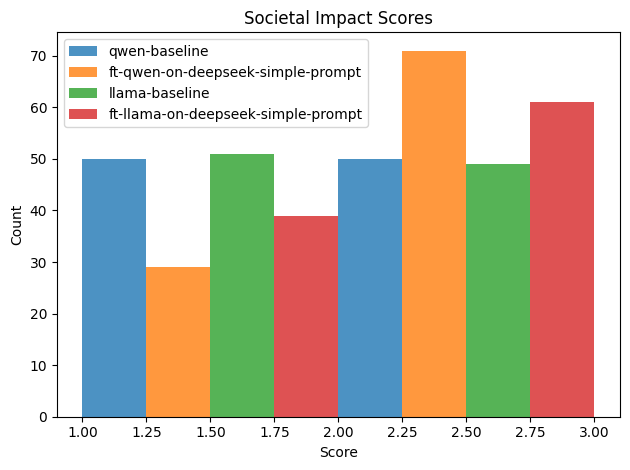

In [112]:
utils.histogram_of_scores(llm_eval_results, 'societal_eval_prompt_scoring_parsed', 'Societal Impact Scores')

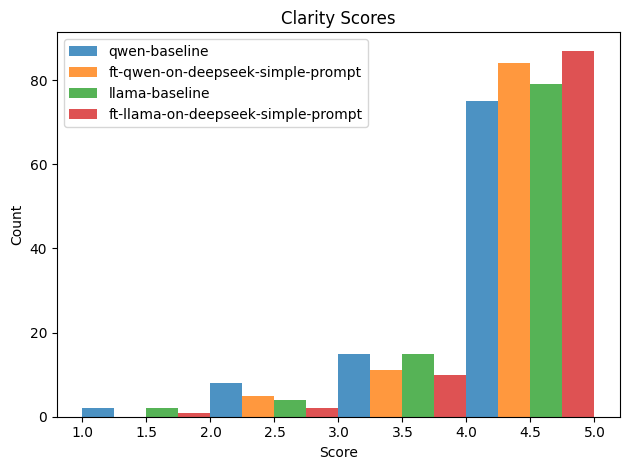

In [103]:
utils.histogram_of_scores(llm_eval_results, 'clarity_eval_prompt_scoring_parsed', 'Clarity Scores')

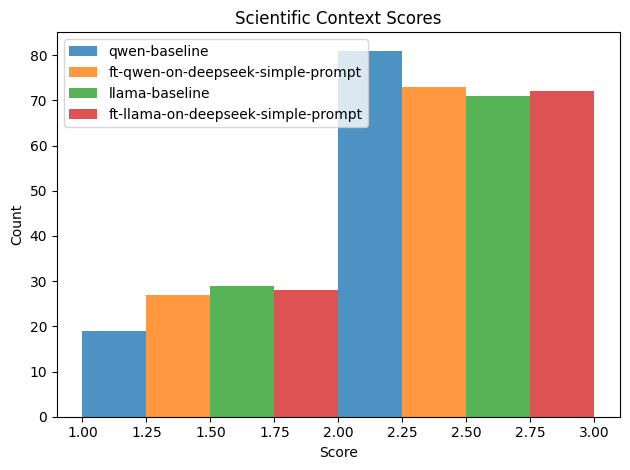

In [104]:
utils.histogram_of_scores(llm_eval_results, 'scientific_eval_prompt_scoring_parsed', 'Scientific Context Scores')